## AMAZON Food Reviews Analysis
LSTM Model for Food Reviews
Adam Goldstein

In [151]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras import models
from keras import layers
from keras import preprocessing, regularizers
from sklearn.metrics import mean_squared_error
import string
import re
import nltk
from nltk.stem.porter import PorterStemmer
# Import early stopping monitor
from keras.callbacks import EarlyStopping

In [152]:
data = pd.read_csv('data/Reviews.csv')

# Convert pickle to panda dataframe
#data = pd.read_csv('Reviews.csv')
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## Initial Data Exploration

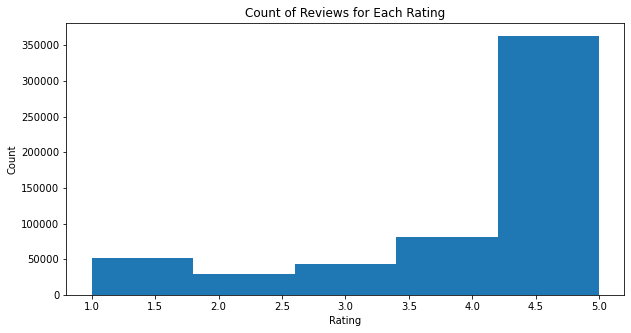

In [153]:
## Plot count of reviews for each rating
plt.figure(figsize=(10,5))
plt.hist(data['Score'], bins=5)
plt.title('Count of Reviews for Each Rating')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

Clearly most of the reviews contained are 5 star ratings, and the majority of the reviews are positive.
Interesting that nobody seems to provide 2 star ratings, I suppose it's due to the fact that a two star is nearly a one star.

## Plot most popular words used in reviews

There are 248540641 words in the combination of all review.


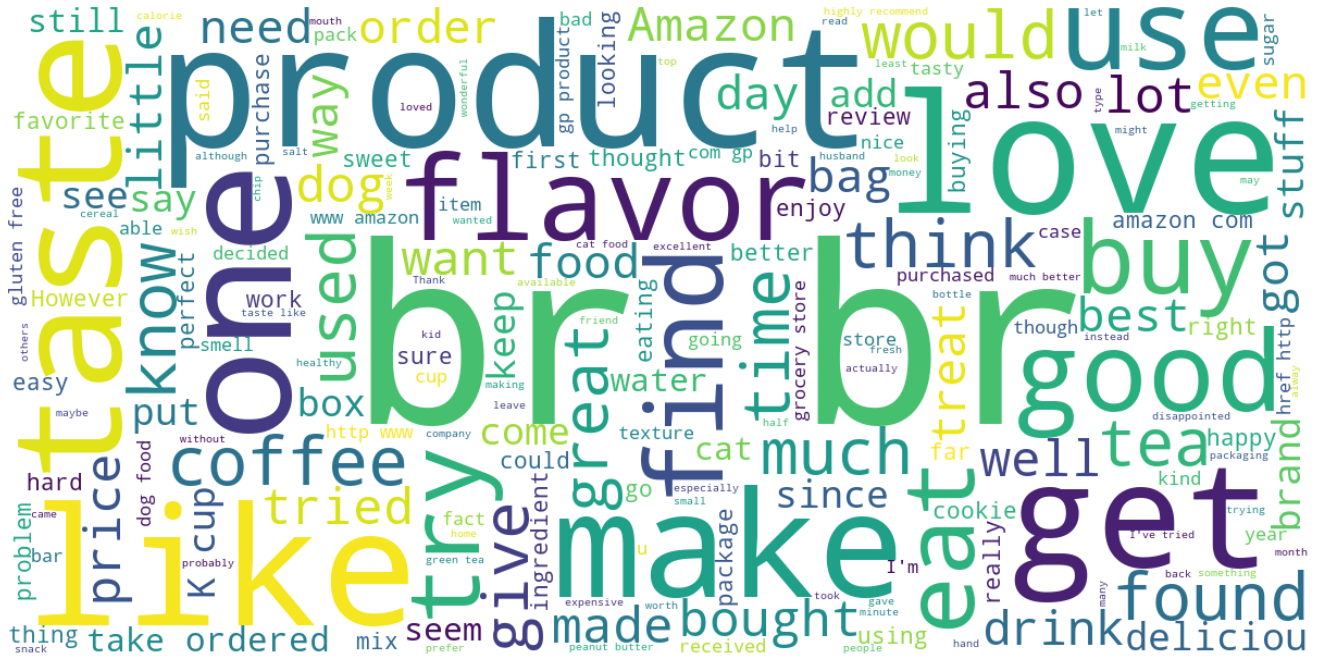

In [154]:
from nltk.corpus import stopwords
from wordcloud import WordCloud

text = " ".join(review for review in data["Text"])
print ("There are {} words in the combination of all review.".format(len(text)))

# Create stopword list:
default_stopwords=set(stopwords.words('english'))

# Generate a word cloud image
wordcloud = WordCloud(stopwords=default_stopwords, background_color="white", width=1200, height=600).generate(text)

# Display the generated image:
plt.figure(figsize=(30,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## This block of code was taken directly from the following link: https://www.kaggle.com/code/naushads/1-2-amazon-fine-food-reviews-eda-data-cleaning-fe/notebook ##

Interesting to see that the most popular words are not very specific, but rather general. 
They are all strong adjectivives such as like, love, tasty, etc.
It certainly shows that these words are specifc to food reviews.

## Preprocessing

In [155]:
# Ignore reviews that have Helpfullness Denominator greater than Numerator
data = data[data['HelpfulnessDenominator'] <= data['HelpfulnessNumerator']]

data = data[['Text', 'Score']]
data['review'] = data['Text']
data['label'] = data['Score']
data.drop(['Text', 'Score'], axis=1, inplace=True)

# Drop neutral reviews
data = data[data['label'] != 3]

# Make ratings either 1 or 0
data['label'] = data['label'].apply(lambda x: 1 if x > 3 else 0)

# Drop duplicates
data = data.drop_duplicates()

## Balance the data


In [156]:
# Balance the data set
#positives = data[data['label'] == 1][:len(data[data['label'] == 0])]
#data = pd.concat([data, positives])


In [157]:
print(data.shape)
print(data.head())

(295892, 2)
                                              review  label
0  I have bought several of the Vitality canned d...      1
1  Product arrived labeled as Jumbo Salted Peanut...      0
2  This is a confection that has been around a fe...      1
3  If you are looking for the secret ingredient i...      0
4  Great taffy at a great price.  There was a wid...      1


In [158]:
# Count positive and negative reviews
print(data['label'].value_counts())

1    266970
0     28922
Name: label, dtype: int64


In [159]:
df = data.copy()

In [160]:
# # Get 20000 positive reviews and 20000 negative reviews
# # data = data.sample(frac=1)
# # data_pos = data[data['label'] == 1][:50000]
# # data_neg = data[data['label'] == 0][:50000]
# # df = pd.concat([data_pos, data_neg])
# df = df.sample(frac=1).reset_index(drop=True)
# df.head()

In [161]:
# Count number of posotive and negative reviews
print(df['label'].value_counts())

1    266970
0     28922
Name: label, dtype: int64


# **NLP word processing**
(These take a while to run, especially stemming)

In [162]:
df['review'] = df['review'].apply(str) #some reviews are floats for some reason

In [163]:
#make lowercase
df['review'] = df['review'].apply(lambda x: x.lower())

In [164]:
#remove punctuation
df['review'] = df['review'].apply(lambda x: "".join([char for char in x if char not in string.punctuation]))

In [165]:
# remove numbers
df['review'] = df['review'].apply(lambda x: re.sub(r'\d+', '', x))

In [166]:
# remove whitespace
df['review'] = df['review'].apply(lambda x: x.strip())

In [167]:
df.head()

,review,label
0,i have bought several of the vitality canned d...,1
1,product arrived labeled as jumbo salted peanut...,0
2,this is a confection that has been around a fe...,1
3,if you are looking for the secret ingredient i...,0
4,great taffy at a great price there was a wide...,1


# Prepare for training

In [168]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(df['review'], df['label'], test_size=0.2, random_state=42)

In [169]:
# Tokenize words
tokenizer = preprocessing.text.Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)

In [170]:
# transform xtrain and xtest
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

## Padding the data

In [171]:
vocab_size = len(tokenizer.word_index) + 1
max_review_len = 150

X_train = preprocessing.sequence.pad_sequences(X_train, maxlen=max_review_len)
X_test = preprocessing.sequence.pad_sequences(X_test, maxlen=max_review_len)

In [172]:
print(vocab_size)

154383


# Build the Model

## Model 1 LSTM

In [173]:
# Build model
model = models.Sequential()
model.add(layers.Embedding(vocab_size, 32))
model.add(layers.LSTM(100))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, None, 32)          4940256   
                                                                 
 lstm_17 (LSTM)              (None, 100)               53200     
                                                                 
 dense_13 (Dense)            (None, 1)                 101       
                                                                 
Total params: 4,993,557
Trainable params: 4,993,557
Non-trainable params: 0
_________________________________________________________________


In [174]:
EarlyStopping = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto')

history = model.fit(X_train, y_train, epochs=10, verbose=1, validation_data=(X_test, y_test), callbacks=[EarlyStopping])
scores = model.evaluate(X_test, y_test, verbose=0)
model.save('lstm_model1.h5')
print("Accuracy: %.2f%%" % (scores[1]*100))

Epoch 1/10
7398/7398 [==============================] - 504s 68ms/step - loss: 0.1583 - accuracy: 0.9414 - val_loss: 0.1189 - val_accuracy: 0.9566
Epoch 2/10
7398/7398 [==============================] - 500s 68ms/step - loss: 0.1025 - accuracy: 0.9618 - val_loss: 0.1032 - val_accuracy: 0.9626
Epoch 3/10
7398/7398 [==============================] - 499s 67ms/step - loss: 0.0819 - accuracy: 0.9695 - val_loss: 0.1031 - val_accuracy: 0.9637
Epoch 4/10
7398/7398 [==============================] - 493s 67ms/step - loss: 0.0679 - accuracy: 0.9749 - val_loss: 0.1066 - val_accuracy: 0.9636
Epoch 5/10
7398/7398 [==============================] - 495s 67ms/step - loss: 0.0559 - accuracy: 0.9797 - val_loss: 0.1079 - val_accuracy: 0.9630
Epoch 5: early stopping
Accuracy: 96.30%


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


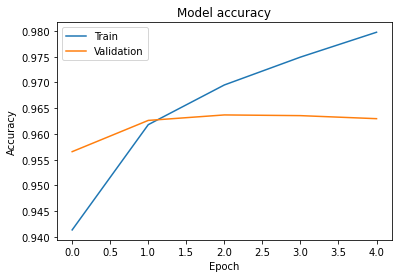

In [175]:
# Plot training & validation accuracy values
print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

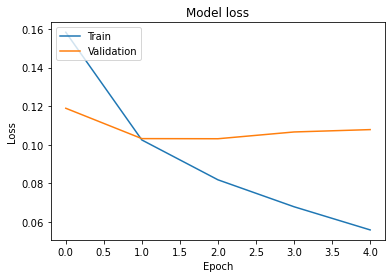

In [176]:
# Plot training and validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

The model successful performed at 95% training accuracy and 92% validation accuracy. Early stopping was enabled to limit the likilhood of overfitting to the training data.
This is the simplest, yet best performing LSTM model so far. The Adam optimzer was used with a learning rate of 0.001. At around 1 epoch the validation loss becan to increase from 0.25 to 0.3 showing concern of overfitting. After 2 epochs the loss decreased once again to 0.25.

In [177]:
# Predict on test data
predictions = model.predict(X_test)
predictions = (predictions > 0.5)
print(predictions)

# Make a fake review to predict on
fake_review_bad = "The food was terrible, and I will not be buying it again"
fake_review_bad = [fake_review_bad]
fake_review_bad = tokenizer.texts_to_sequences(fake_review_bad)
fake_review_bad = preprocessing.sequence.pad_sequences(fake_review_bad, maxlen=max_review_len)

predict_bad = model.predict(fake_review_bad)
print(predict_bad)

fake_review_good = "The food was amazing, and I will be buying it again"
fake_review_good = [fake_review_good]
fake_review_good = tokenizer.texts_to_sequences(fake_review_good)
fake_review_good = preprocessing.sequence.pad_sequences(fake_review_good, maxlen=max_review_len)

predict_good = model.predict(fake_review_good)
print(predict_good)

# Calculate F1 score
from sklearn.metrics import f1_score

predictions = model.predict(X_test)
predictions = (predictions > 0.5)

print(f1_score(y_test, predictions))

[[ True]
 [ True]
 [ True]
 ...
 [ True]
 [ True]
 [ True]]
[[0.00121483]]
[[0.99990726]]
0.9796032307291472


## Tuning the LSTM

### Model 2 LSTM

In [178]:
# Build the model
model = models.Sequential()
model.add(layers.Embedding(vocab_size, 32))
model.add(layers.LSTM(100, return_sequences=True)) #return_sequences=True to return the last output of the LSTM
model.add(layers.LSTM(100)) # Add second LSTM layer
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, None, 32)          4940256   
                                                                 
 lstm_18 (LSTM)              (None, None, 100)         53200     
                                                                 
 lstm_19 (LSTM)              (None, 100)               80400     
                                                                 
 dense_14 (Dense)            (None, 1)                 101       
                                                                 
Total params: 5,073,957
Trainable params: 5,073,957
Non-trainable params: 0
_________________________________________________________________


In [179]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# EarlyStopping = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto')


# Trying a different batch size
history = model.fit(X_train, y_train, epochs=10, verbose=1, validation_data=(X_test, y_test), batch_size = 128, callbacks=[EarlyStopping])
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))
model.save('lstm_model2.h5')

Epoch 1/10
1850/1850 [==============================] - 359s 193ms/step - loss: 0.1632 - accuracy: 0.9396 - val_loss: 0.1357 - val_accuracy: 0.9498
Epoch 2/10
1850/1850 [==============================] - 371s 201ms/step - loss: 0.1183 - accuracy: 0.9559 - val_loss: 0.1149 - val_accuracy: 0.9573
Epoch 3/10
1850/1850 [==============================] - 351s 190ms/step - loss: 0.0912 - accuracy: 0.9662 - val_loss: 0.1100 - val_accuracy: 0.9619
Epoch 4/10
1850/1850 [==============================] - 364s 197ms/step - loss: 0.0752 - accuracy: 0.9727 - val_loss: 0.1147 - val_accuracy: 0.9609
Epoch 5/10
1850/1850 [==============================] - 341s 184ms/step - loss: 0.0628 - accuracy: 0.9773 - val_loss: 0.1133 - val_accuracy: 0.9605
Epoch 5: early stopping
Accuracy: 96.05%


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


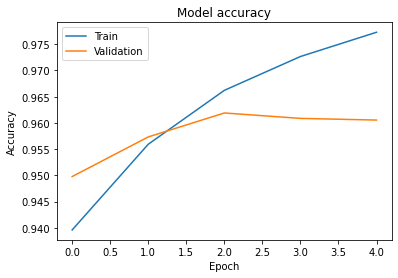

In [180]:
# Plot training & validation accuracy values
print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

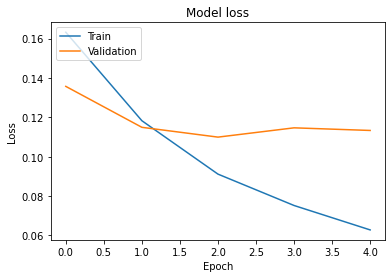

In [181]:
# Plot training and validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

In [182]:
# Calculate F1 score
from sklearn.metrics import f1_score

predictions = model.predict(X_test)
predictions = (predictions > 0.5)

print(f1_score(y_test, predictions))

0.978158995033159


### Model 3 LSTM

Altered embedding layer size to 100.

In [183]:

model = models.Sequential()
model.add(layers.Embedding(vocab_size, 32))
model.add(layers.LSTM(100))
model.add(layers.Dropout(0.9))
model.add(layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.001)))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()




Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, None, 32)          4940256   
                                                                 
 lstm_20 (LSTM)              (None, 100)               53200     
                                                                 
 dropout_4 (Dropout)         (None, 100)               0         
                                                                 
 dense_15 (Dense)            (None, 1)                 101       
                                                                 
Total params: 4,993,557
Trainable params: 4,993,557
Non-trainable params: 0
_________________________________________________________________


In [184]:
history = model.fit(X_train, y_train, epochs=10, verbose=1, validation_data=(X_test, y_test), callbacks=[EarlyStopping])

Epoch 1/10
7398/7398 [==============================] - 482s 65ms/step - loss: 0.1815 - accuracy: 0.9371 - val_loss: 0.1485 - val_accuracy: 0.9445
Epoch 2/10
7398/7398 [==============================] - 500s 68ms/step - loss: 0.1268 - accuracy: 0.9547 - val_loss: 0.1193 - val_accuracy: 0.9578
Epoch 3/10
7398/7398 [==============================] - 505s 68ms/step - loss: 0.1077 - accuracy: 0.9622 - val_loss: 0.1181 - val_accuracy: 0.9593
Epoch 4/10
7398/7398 [==============================] - 499s 67ms/step - loss: 0.0957 - accuracy: 0.9666 - val_loss: 0.1186 - val_accuracy: 0.9619
Epoch 5/10
7398/7398 [==============================] - 508s 69ms/step - loss: 0.0846 - accuracy: 0.9714 - val_loss: 0.1139 - val_accuracy: 0.9604
Epoch 6/10
7398/7398 [==============================] - 519s 70ms/step - loss: 0.0772 - accuracy: 0.9739 - val_loss: 0.1294 - val_accuracy: 0.9615
Epoch 7/10
7398/7398 [==============================] - 475s 64ms/step - loss: 0.0699 - accuracy: 0.9770 - val_loss: 0

In [185]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))
model.save('lstm_model3.h5')

Accuracy: 95.32%


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


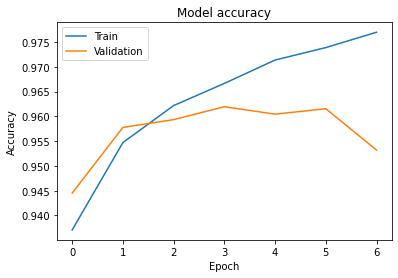

In [186]:
# Plot training & validation accuracy values
print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

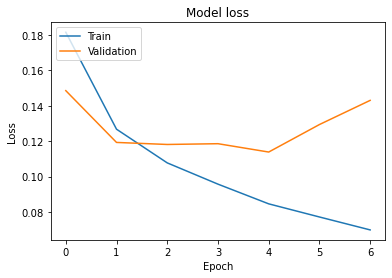

In [187]:
# Plot training and validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

In [188]:
predictions = model.predict(X_test)
predictions = (predictions > 0.5)

print(f1_score(y_test, predictions))

0.9738694036186631
